
(lgm-groups-notebook)=
# Modelli di crescita latenti a gruppi multipli

Nel capitolo precedente abbiamo esaminato i modelli di crescita con covariate invarianti nel tempo. Ora considereremo un quadro alternativo per esaminare le differenze tra le persone nel cambiamento: il confronto tra gruppi (McArdle, 1989; McArdle & Hamagami, 1996). I modelli di crescita con covariate invarianti nel tempo sono utili per studiare le differenze nelle traiettorie medie di crescita ma hanno una utilità limitata per esaminare le differenze in altri aspetti del processo di cambiamento intra-persona e le differenze tra le persone in quel processo. Senza estensione, tali modelli di covariate invarianti nel tempo non ci dicono nulla sulle differenze nelle varianze e covarianze tra i fattori di crescita, la variabilità residua e la struttura dei cambiamenti intra-persona. In questo capitolo illustriamo come il confronto tra gruppi possa essere utilizzato per esaminare le differenze in qualsiasi aspetto del modello di crescita. Questa flessibilità può fornire ulteriori informazioni su come e perché gli individui differiscono nel loro sviluppo.

Carichiamo i pacchetti necessari.

In [1]:
source("_common.R")
suppressPackageStartupMessages({
    library("lavaan")
    library("semPlot")
    library("knitr")
    library("markdown")
    library("patchwork")
    library("psych")
    library("DT")
    library("kableExtra")
    library("lme4")
})

set.seed(42)

Per i nostri esempi, utilizziamo i punteggi di rendimento in matematica dai dati  NLSY-CYA [si veda {cite:t}`grimm2016growth`]. Iniziamo a leggere i dati.

In [2]:
# set filepath for data file
filepath <- "https://raw.githubusercontent.com/LRI-2/Data/main/GrowthModeling/nlsy_math_long_R.dat"
# read in the text data file using the url() function
dat <- read.table(
  file = url(filepath),
  na.strings = "."
) # indicates the missing data designator
# copy data with new name
nlsy_math_long <- dat

# Add names the columns of the data set
names(nlsy_math_long) <- c(
  "id", "female", "lb_wght",
  "anti_k1", "math", "grade",
  "occ", "age", "men",
  "spring", "anti"
)

# reducing to variables of interest
nlsy_math_long <- nlsy_math_long[, c("id", "grade", "math", "lb_wght")]

# adding another dummy code variable for normal birth weight that coded the opposite of the low brithweight variable.
nlsy_math_long$nb_wght <- 1 - nlsy_math_long$lb_wght

# view the first few observations in the data set
head(nlsy_math_long, 10)

,id,grade,math,lb_wght,nb_wght
,<int>,<int>,<int>,<int>,<dbl>
1,201,3,38,0,1
2,201,5,55,0,1
3,303,2,26,0,1
4,303,5,33,0,1
5,2702,2,56,0,1
6,2702,4,58,0,1
7,2702,8,80,0,1
8,4303,3,41,0,1
9,4303,4,58,0,1


Esaminiamo le curve di crescita nei due gruppi.


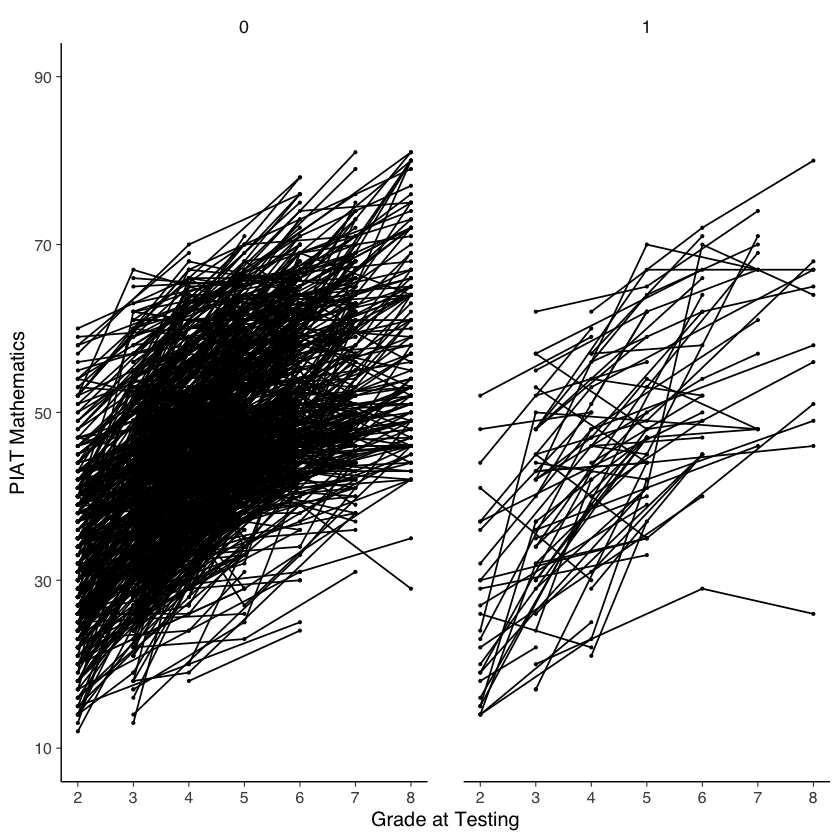

In [3]:
# intraindividual change trajetories
ggplot(
  data = nlsy_math_long, # data set
  aes(x = grade, y = math, group = id)
) + # setting variables
  geom_point(size = .5) + # adding points to plot
  geom_line() + # adding lines to plot
  # setting the x-axis with breaks and labels
  scale_x_continuous(
    limits = c(2, 8),
    breaks = c(2, 3, 4, 5, 6, 7, 8),
    name = "Grade at Testing"
  ) +
  # setting the y-axis with limits breaks and labels
  scale_y_continuous(
    limits = c(10, 90),
    breaks = c(10, 30, 50, 70, 90),
    name = "PIAT Mathematics"
  ) +
  facet_wrap(~lb_wght)

Per semplicità, carichiamo di nuovo i dati già trasformati in formato wide.

In [4]:
# set filepath for data file
filepath <- "https://raw.githubusercontent.com/LRI-2/Data/main/GrowthModeling/nlsy_math_wide_R.dat"
# read in the text data file using the url() function
dat <- read.table(
  file = url(filepath),
  na.strings = "."
) # indicates the missing data designator
# copy data with new name
nlsy_math_wide <- dat

# Give the variable names
names(nlsy_math_wide) <- c(
  "id", "female", "lb_wght", "anti_k1",
  "math2", "math3", "math4", "math5", "math6", "math7", "math8",
  "age2", "age3", "age4", "age5", "age6", "age7", "age8",
  "men2", "men3", "men4", "men5", "men6", "men7", "men8",
  "spring2", "spring3", "spring4", "spring5", "spring6", "spring7", "spring8",
  "anti2", "anti3", "anti4", "anti5", "anti6", "anti7", "anti8"
)

# view the first few observations (and columns) in the data set
head(nlsy_math_wide[, 1:11], 10)

,id,female,lb_wght,anti_k1,math2,math3,math4,math5,math6,math7,math8
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,201,1,0,0,NA,38,NA,55,NA,NA,NA
2,303,1,0,1,26,NA,NA,33,NA,NA,NA
3,2702,0,0,0,56,NA,58,NA,NA,NA,80
4,4303,1,0,0,NA,41,58,NA,NA,NA,NA
5,5002,0,0,4,NA,NA,46,NA,54,NA,66
6,5005,1,0,0,35,NA,50,NA,60,NA,59
7,5701,0,0,2,NA,62,61,NA,NA,NA,NA
8,6102,0,0,0,NA,NA,55,67,NA,81,NA
9,6801,1,0,0,NA,54,NA,62,NA,66,NA


## Invarianza tra gruppi

Definiamo il modello di crescita latente per i due gruppi.

In [5]:
# writing out linear growth model in full SEM way
mg_math_lavaan_model <- "
  # latent variable definitions
      #intercept (note intercept is a reserved term)
      eta_1 =~ 1*math2
      eta_1 =~ 1*math3
      eta_1 =~ 1*math4
      eta_1 =~ 1*math5
      eta_1 =~ 1*math6
      eta_1 =~ 1*math7
      eta_1 =~ 1*math8

      #linear slope
      eta_2 =~ 0*math2
      eta_2 =~ 1*math3
      eta_2 =~ 2*math4
      eta_2 =~ 3*math5
      eta_2 =~ 4*math6
      eta_2 =~ 5*math7
      eta_2 =~ 6*math8

  # factor variances
      eta_1 ~~ eta_1
      eta_2 ~~ eta_2

  # covariances among factors
      eta_1 ~~ eta_2

  # factor means
      eta_1 ~ start(35)*1
      eta_2 ~ start(4)*1

  # manifest variances (made equivalent by naming theta)
      math2 ~~ theta*math2
      math3 ~~ theta*math3
      math4 ~~ theta*math4
      math5 ~~ theta*math5
      math6 ~~ theta*math6
      math7 ~~ theta*math7
      math8 ~~ theta*math8
  # manifest means (fixed at zero)
      math2 ~ 0*1
      math3 ~ 0*1
      math4 ~ 0*1
      math5 ~ 0*1
      math6 ~ 0*1
      math7 ~ 0*1
      math8 ~ 0*1
" # end of model definition

Adattiamo il modello ai dati specificando la separazione delle osservazioni in due gruppi e introducendo i vincoli di eguaglianza tra gruppi sulle saturazioni fattoriali, le medie, le varianze, le covarianze, e i residui. In questo modello, sostanzialmente, non c'è alcune differenza tra gruppi.

In [6]:
mg_math_lavaan_fitM1 <- sem(mg_math_lavaan_model,
  data = nlsy_math_wide,
  meanstructure = TRUE,
  estimator = "ML",
  missing = "fiml",
  group = "lb_wght", # to separate groups
  group.equal = c(
    "loadings", # for constraints
    "means",
    "lv.variances",
    "lv.covariances",
    "residuals"
  )
)

Warning message in lav_data_full(data = data, group = group, cluster = cluster, :
“lavaan WARNING: some cases are empty and will be ignored:
  741”


Warning message in lav_data_full(data = data, group = group, cluster = cluster, :
“lavaan WARNING:
    due to missing values, some pairwise combinations have less than
    10% coverage; use lavInspect(fit, "coverage") to investigate.”


Warning message in lav_data_full(data = data, group = group, cluster = cluster, :
“lavaan WARNING:
    due to missing values, some pairwise combinations have 0%
    coverage; use lavInspect(fit, "coverage") to investigate.”


Warning message in lav_mvnorm_missing_h1_estimate_moments(Y = X[[g]], wt = WT[[g]], :
“lavaan WARNING:
    Maximum number of iterations reached when computing the sample
    moments using EM; use the em.h1.iter.max= argument to increase the
    number of iterations”


Warning message in lav_mvnorm_missing_h1_estimate_moments(Y = X[[g]], wt = WT[[g]], :
“lavaan WARNING:
    Maximum number of iterations reached when computing the sample
    moments using EM; use the em.h1.iter.max= argument to increase the
    number of iterations”


Esaminiamo il risultato

In [7]:
summary(mg_math_lavaan_fitM1, fit.measures = TRUE) |>
    print()

lavaan 0.6.15 ended normally after 24 iterations

  Estimator                                         ML
  Optimization method                           NLMINB
  Number of model parameters                        24
  Number of equality constraints                    18

  Number of observations per group:               Used       Total
    0                                              857         858
    1                                               75          75
  Number of missing patterns per group:                           
    0                                               60            
    1                                               25            

Model Test User Model:
                                                      
  Test statistic                               249.111
  Degrees of freedom                                64
  P-value (Chi-square)                           0.000
  Test statistic for each group:
    0                                          191

Creiamo il diagramma di percorso.


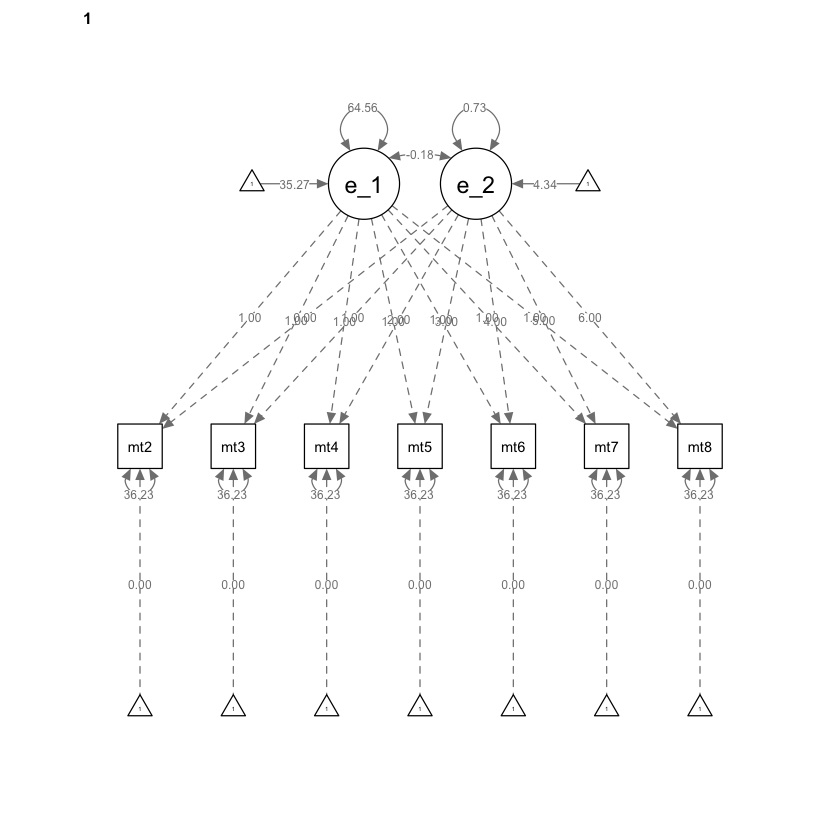

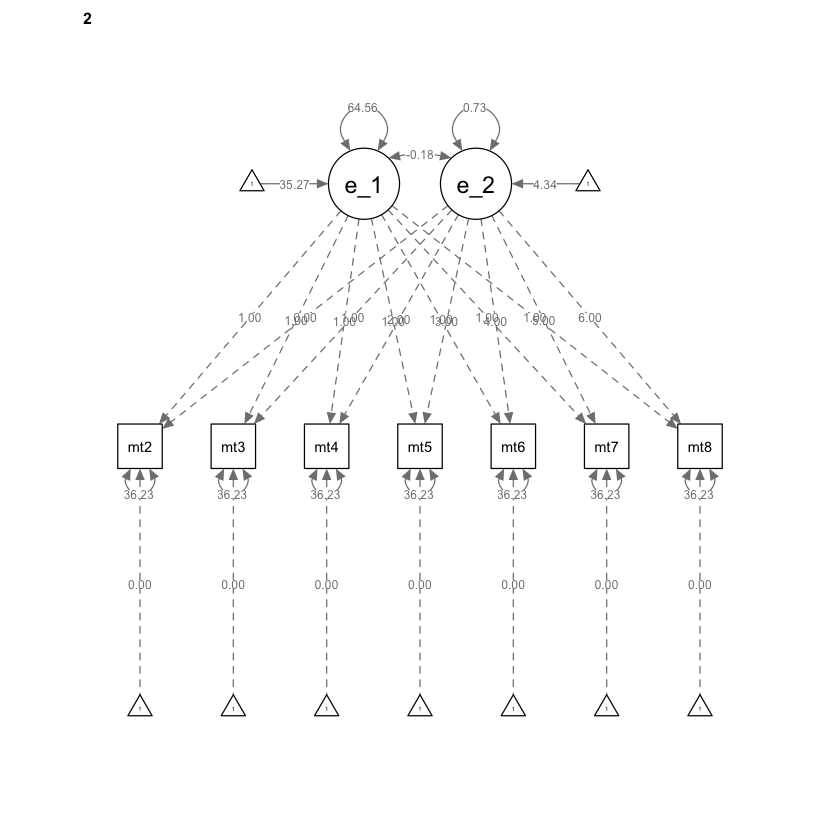

In [8]:
semPaths(mg_math_lavaan_fitM1, what = "path", whatLabels = "par")

## Vincoli sulle medie

Trasformiamo ora il modello restrittivo specificato in precedenza allentando via via i vincoli che abbiamo introdotto. In questo modello rendiamo possibile la differenza tra le medie nei due gruppi.

In [9]:
mg_math_lavaan_fitM2 <- sem(mg_math_lavaan_model,
  data = nlsy_math_wide,
  meanstructure = TRUE,
  estimator = "ML",
  missing = "fiml",
  group = "lb_wght", # to separate groups
  group.equal = c(
    "loadings", # for constraints
    # "means", commented out so can differ
    "lv.variances",
    "lv.covariances",
    "residuals"
  )
)

Warning message in lav_data_full(data = data, group = group, cluster = cluster, :
“lavaan WARNING: some cases are empty and will be ignored:
  741”


Warning message in lav_data_full(data = data, group = group, cluster = cluster, :
“lavaan WARNING:
    due to missing values, some pairwise combinations have less than
    10% coverage; use lavInspect(fit, "coverage") to investigate.”


Warning message in lav_data_full(data = data, group = group, cluster = cluster, :
“lavaan WARNING:
    due to missing values, some pairwise combinations have 0%
    coverage; use lavInspect(fit, "coverage") to investigate.”


Warning message in lav_mvnorm_missing_h1_estimate_moments(Y = X[[g]], wt = WT[[g]], :
“lavaan WARNING:
    Maximum number of iterations reached when computing the sample
    moments using EM; use the em.h1.iter.max= argument to increase the
    number of iterations”


Warning message in lav_mvnorm_missing_h1_estimate_moments(Y = X[[g]], wt = WT[[g]], :
“lavaan WARNING:
    Maximum number of iterations reached when computing the sample
    moments using EM; use the em.h1.iter.max= argument to increase the
    number of iterations”


Esaminiamo il risultato.

In [10]:
summary(mg_math_lavaan_fitM2, fit.measures = TRUE) |>
    print()

lavaan 0.6.15 ended normally after 31 iterations

  Estimator                                         ML
  Optimization method                           NLMINB
  Number of model parameters                        24
  Number of equality constraints                    16

  Number of observations per group:               Used       Total
    0                                              857         858
    1                                               75          75
  Number of missing patterns per group:                           
    0                                               60            
    1                                               25            

Model Test User Model:
                                                      
  Test statistic                               243.910
  Degrees of freedom                                62
  P-value (Chi-square)                           0.000
  Test statistic for each group:
    0                                          191

Eseguiamo il confronto tra i due modelli.

In [11]:
anova(mg_math_lavaan_fitM1, mg_math_lavaan_fitM2)

,Df,AIC,BIC,Chisq,Chisq diff,RMSEA,Df diff,Pr(>Chisq)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
mg_math_lavaan_fitM2,62,15948.19,15986.88,243.9101,NA,NA,NA,NA
mg_math_lavaan_fitM1,64,15949.39,15978.41,249.1106,5.200516,0.05860059,2,0.07425443


Non vi è evidenza che consentire una differenza tra medie tra gruppi migliori l'adattamento del modello.

## Vincoli sulle varianze/covarianze

Nel modello M3 consentiamo che anche le varianza e le covarianza differiscano tra gruppi, oltre alle medie.

In [12]:
mg_math_lavaan_fitM3 <- sem(mg_math_lavaan_model,
  data = nlsy_math_wide,
  meanstructure = TRUE,
  estimator = "ML",
  missing = "fiml",
  group = "lb_wght", # to separate groups
  group.equal = c(
    "loadings", # for constraints
    # "means", commented out so can differ
    # "lv.variances",
    # "lv.covariances",
    "residuals"
  )
)

Warning message in lav_data_full(data = data, group = group, cluster = cluster, :
“lavaan WARNING: some cases are empty and will be ignored:
  741”


Warning message in lav_data_full(data = data, group = group, cluster = cluster, :
“lavaan WARNING:
    due to missing values, some pairwise combinations have less than
    10% coverage; use lavInspect(fit, "coverage") to investigate.”


Warning message in lav_data_full(data = data, group = group, cluster = cluster, :
“lavaan WARNING:
    due to missing values, some pairwise combinations have 0%
    coverage; use lavInspect(fit, "coverage") to investigate.”


Warning message in lav_mvnorm_missing_h1_estimate_moments(Y = X[[g]], wt = WT[[g]], :
“lavaan WARNING:
    Maximum number of iterations reached when computing the sample
    moments using EM; use the em.h1.iter.max= argument to increase the
    number of iterations”


Warning message in lav_mvnorm_missing_h1_estimate_moments(Y = X[[g]], wt = WT[[g]], :
“lavaan WARNING:
    Maximum number of iterations reached when computing the sample
    moments using EM; use the em.h1.iter.max= argument to increase the
    number of iterations”


Esaminiamo i risultati.

In [13]:
summary(mg_math_lavaan_fitM3, fit.measures = TRUE) |>
    print()

lavaan 0.6.15 ended normally after 57 iterations

  Estimator                                         ML
  Optimization method                           NLMINB
  Number of model parameters                        24
  Number of equality constraints                    13

  Number of observations per group:               Used       Total
    0                                              857         858
    1                                               75          75
  Number of missing patterns per group:                           
    0                                               60            
    1                                               25            

Model Test User Model:
                                                      
  Test statistic                               241.182
  Degrees of freedom                                59
  P-value (Chi-square)                           0.000
  Test statistic for each group:
    0                                          191

Confrontiamo il modello M2 con il modello M3.

In [14]:
anova(mg_math_lavaan_fitM2, mg_math_lavaan_fitM3)

,Df,AIC,BIC,Chisq,Chisq diff,RMSEA,Df diff,Pr(>Chisq)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
mg_math_lavaan_fitM3,59,15951.46,16004.67,241.1818,NA,NA,NA,NA
mg_math_lavaan_fitM2,62,15948.19,15986.88,243.9101,2.728298,0,3,0.4354397


Non ci sono evidenze che una differenza nelle varianze e nelle covarianze tra gruppi migliori la bontà dell'adattamento del modello ai dati.

## Vincoli sui residui

Esaminiamo ora il vincolo sulle covarianze residue. Iniziamo a specificare il modello in una nuova forma.

In [15]:
mg_math_lavaan_model4 <- "
  # latent variable definitions
      #intercept (note intercept is a reserved term)
      eta_1 =~ 1*math2
      eta_1 =~ 1*math3
      eta_1 =~ 1*math4
      eta_1 =~ 1*math5
      eta_1 =~ 1*math6
      eta_1 =~ 1*math7
      eta_1 =~ 1*math8

      #linear slope
      eta_2 =~ 0*math2
      eta_2 =~ 1*math3
      eta_2 =~ 2*math4
      eta_2 =~ 3*math5
      eta_2 =~ 4*math6
      eta_2 =~ 5*math7
      eta_2 =~ 6*math8

  # factor variances
      eta_1 ~~ start(60)*eta_1
      eta_2 ~~ start(.75)*eta_2

  # covariances among factors
      eta_1 ~~ eta_2

  # factor means
      eta_1 ~ start(35)*1
      eta_2 ~ start(4)*1

  # manifest variances (made equivalent by naming theta)
      math2 ~~ c(theta1,theta2)*math2
      math3 ~~ c(theta1,theta2)*math3
      math4 ~~ c(theta1,theta2)*math4
      math5 ~~ c(theta1,theta2)*math5
      math6 ~~ c(theta1,theta2)*math6
      math7 ~~ c(theta1,theta2)*math7
      math8 ~~ c(theta1,theta2)*math8
  # manifest means (fixed at zero)
      math2 ~ 0*1
      math3 ~ 0*1
      math4 ~ 0*1
      math5 ~ 0*1
      math6 ~ 0*1
      math7 ~ 0*1
      math8 ~ 0*1
" # end of model definition

Adattiamo il modello ai dati.

In [16]:
mg_math_lavaan_fitM4 <- sem(mg_math_lavaan_model4,
  data = nlsy_math_wide,
  meanstructure = TRUE,
  estimator = "ML",
  missing = "fiml",
  group = "lb_wght", # to separate groups
  group.equal = c("loadings")
) # for constraints

Warning message in lav_data_full(data = data, group = group, cluster = cluster, :
“lavaan WARNING: some cases are empty and will be ignored:
  741”


Warning message in lav_data_full(data = data, group = group, cluster = cluster, :
“lavaan WARNING:
    due to missing values, some pairwise combinations have less than
    10% coverage; use lavInspect(fit, "coverage") to investigate.”


Warning message in lav_data_full(data = data, group = group, cluster = cluster, :
“lavaan WARNING:
    due to missing values, some pairwise combinations have 0%
    coverage; use lavInspect(fit, "coverage") to investigate.”


Warning message in lav_mvnorm_missing_h1_estimate_moments(Y = X[[g]], wt = WT[[g]], :
“lavaan WARNING:
    Maximum number of iterations reached when computing the sample
    moments using EM; use the em.h1.iter.max= argument to increase the
    number of iterations”


Warning message in lav_mvnorm_missing_h1_estimate_moments(Y = X[[g]], wt = WT[[g]], :
“lavaan WARNING:
    Maximum number of iterations reached when computing the sample
    moments using EM; use the em.h1.iter.max= argument to increase the
    number of iterations”


Warning message in lav_object_post_check(object):
“lavaan WARNING: some estimated lv variances are negative”


Esaminiamo i risulati.

In [17]:
summary(mg_math_lavaan_fitM4, fit.measures = TRUE) |>
    print()

lavaan 0.6.15 ended normally after 62 iterations

  Estimator                                         ML
  Optimization method                           NLMINB
  Number of model parameters                        24
  Number of equality constraints                    12

  Number of observations per group:               Used       Total
    0                                              857         858
    1                                               75          75
  Number of missing patterns per group:                           
    0                                               60            
    1                                               25            

Model Test User Model:
                                                      
  Test statistic                               237.836
  Degrees of freedom                                58
  P-value (Chi-square)                           0.000
  Test statistic for each group:
    0                                          190

Facciamo un confronto tra la bontà di adattamento del modello M3 e del modello M4.

In [18]:
anova(mg_math_lavaan_fitM3, mg_math_lavaan_fitM4) |>
    print()


Chi-Squared Difference Test

                     Df   AIC   BIC  Chisq Chisq diff    RMSEA Df diff
mg_math_lavaan_fitM4 58 15950 16008 237.84                            
mg_math_lavaan_fitM3 59 15952 16005 241.18     3.3457 0.070948       1
                     Pr(>Chisq)  
mg_math_lavaan_fitM4             
mg_math_lavaan_fitM3    0.06738 .
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Anche in questo caso non otteniamo un risultato che fornisce evidenza di differenze tra i due gruppi.

## Conclusioni

In conclusione, possiamo dire che le evidenze presenti suggeriscono che i modelli di crescita latente per di due gruppi hanno parametri uguali per ciò che concerne le saturazioni fattoriali, le medie, le varianze, le covarianze e i residui. 